# Digit Recognition Kaggle Competition

The goal of this competition is to correctly identify digits from handwritten images. This notebook originated as an assignment from my Data Science Immersive with General Assembly. Credit is indicated for code referenced from our lessons.

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.python.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC

In [83]:
data = pd.read_csv('train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
data.shape

(42000, 785)

In [85]:
# Define X and y
X = data.drop(columns=['label'])
y = data['label']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [86]:
# find the highest value in the datasets
X_train.max().max(), X_test.max().max()

(255, 255)

In [87]:
# find the lowest value in the dataset
X_train.min().min(), X_test.min().min()

(0, 0)

## Preprocessing

### Scaling
To improve computational efficiency, scale the data from 0 to 1.

In [88]:
# Make sure each value is a float and scale
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [89]:
# Change X train and X test to an array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [90]:
# Check shape of full training data.
# this is the number of images by 28**2
X_train.shape

(31500, 784)

### Reshape 

The neural networks require the input data to have 4 dimensions _(batch_size, height, width, depth)_. The depth dimension represents the number of color channels, or how dark the pixel is (in this case 1 for greyscale rather than 3 for an RGB image).

In [91]:
# Reshape for neural net 31500 x 28 x 28 x 1.
X_train_nn = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test_nn = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train_nn.shape

(31500, 28, 28, 1)

### Encode target variable
The target variable needs to be categorical or the neural network will try to make predictions based on what is numerically close to the true value.

In [92]:
# one hot encode the target variables - there are 10 digit categories
y_train_nn = utils.to_categorical(y_train, 10)
y_test_nn = utils.to_categorical(y_test, 10)

In [93]:
# Check y_train. Now its a one hot encoded array
y_train_nn[0:10]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

# Modeling

## Support Vector Machine
Test a SVM model, which is a more general form of a support vector classifier that can have non-linear separation between classes. Since there are many features, gridsearch over all the default kernals.

In [94]:
# Gridsearch over different hyperparameters

svc_params={
    'kernel':['linear','poly','rbf','sigmoid'],
    'C':[0.1,1,2],
    'gamma':['scale', 'auto']}

# Fit to training data
svc_gs=GridSearchCV(SVC(random_state=42),
                    param_grid=svc_params,
                    cv=5)

svc_gs.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Evaluate model
print(f"Test score: {svc_gs.score(X_train, y_train)}")
print(f"Test score: {svc_gs.score(X_test, y_test)}")
print(f"Best params: {svc_gs.best_params_}")

## Keras Sequential Model

In [28]:
sq_model = Sequential()

In [29]:
# Add a flatten layer first before dense layers
sq_model.add(Flatten(input_shape=(28,28,1)))

# Create the network
sq_model.add(Dense(128, activation='relu'))
sq_model.add(Dense(32, activation='relu'))
sq_model.add(Dense(10, activation='softmax'))

# Compile model
sq_model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

In [30]:
# Fit to training data
history_sq = sq_model.fit(X_train_nn,
                    y_train_nn, 
                    batch_size=256, 
                    validation_data=(X_test, y_test),
                    epochs=5,
                    verbose=1)

Train on 31500 samples, validate on 10500 samples
Epoch 1/5
31500/31500 [==============================] - 3s 100us/sample - loss: 0.6661 - accuracy: 0.8092 - val_loss: 0.2865 - val_accuracy: 0.9197
Epoch 2/5
31500/31500 [==============================] - 2s 52us/sample - loss: 0.2328 - accuracy: 0.9339 - val_loss: 0.2076 - val_accuracy: 0.9400
Epoch 3/5
31500/31500 [==============================] - 2s 56us/sample - loss: 0.1775 - accuracy: 0.9490 - val_loss: 0.1731 - val_accuracy: 0.9490
Epoch 4/5
31500/31500 [==============================] - 2s 52us/sample - loss: 0.1463 - accuracy: 0.9580 - val_loss: 0.1442 - val_accuracy: 0.9596
Epoch 5/5
31500/31500 [==============================] - 2s 52us/sample - loss: 0.1178 - accuracy: 0.9674 - val_loss: 0.1406 - val_accuracy: 0.9598


In [32]:
sq_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 104,938
Trainable params: 104,938
Non-trainable params: 0
_________________________________________________________________


## Keras Convolutional Model

In [29]:
# Instantiate a CNN.
cnn_model = Sequential()

In [31]:
# Add a convolutional layer.
cnn_model.add(Conv2D(filters = 6,           
                     kernel_size = (3,3),       
                     activation='relu',       
                     input_shape=(28,28,1))) 

In [32]:
cnn_model.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

In [33]:
cnn_model.add(Conv2D(filters= 16,
                     kernel_size=(3,3),
                     activation='relu'))

In [34]:
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

In [35]:
cnn_model.add(Flatten())

In [37]:
# Add a densely-connected layer with 128 neurons.
cnn_model.add(Dense(128, activation='relu'))

# Add a final layer with 10 neurons.
cnn_model.add(Dense(10,activation='softmax'))

In [38]:
# Compile model - exactly the same
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [51]:
# Fit model on training data
history_cnn = cnn_model.fit(X_train,
                        y_train,
                        batch_size=256,
                        validation_data=(X_test, y_test),
                        epochs=5,
                        verbose=1)

Train on 31500 samples, validate on 10500 samples
Epoch 1/5
31500/31500 [==============================] - 28s 886us/sample - loss: 0.0609 - accuracy: 0.9810 - val_loss: 0.0671 - val_accuracy: 0.9797
Epoch 2/5
31500/31500 [==============================] - 27s 859us/sample - loss: 0.0553 - accuracy: 0.9830 - val_loss: 0.0708 - val_accuracy: 0.9775
Epoch 3/5
31500/31500 [==============================] - 29s 922us/sample - loss: 0.0484 - accuracy: 0.9852 - val_loss: 0.0648 - val_accuracy: 0.9805
Epoch 4/5
31500/31500 [==============================] - 30s 944us/sample - loss: 0.0433 - accuracy: 0.9867 - val_loss: 0.0650 - val_accuracy: 0.9802
Epoch 5/5
31500/31500 [==============================] - 27s 870us/sample - loss: 0.0368 - accuracy: 0.9888 - val_loss: 0.0527 - val_accuracy: 0.9849


In [40]:
# Check out the model summary.
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 6)         60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               51328     
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [44]:
cnn_model.predict(kaggle_test)

array([[1.3876638e-08, 3.6718037e-10, 9.9999273e-01, ..., 2.5367443e-08,
        2.4895684e-08, 5.9174943e-10],
       [9.9701166e-01, 1.4200369e-08, 5.4283859e-04, ..., 2.5912477e-06,
        3.8177444e-05, 2.8767638e-04],
       [2.1755146e-05, 9.0521964e-05, 4.8160079e-04, ..., 6.8793386e-05,
        1.2266451e-02, 9.8440844e-01],
       ...,
       [8.4050384e-09, 2.0083372e-07, 1.9505567e-06, ..., 3.1667651e-07,
        1.5601639e-06, 3.1139396e-07],
       [1.9947656e-05, 1.5137462e-07, 1.6691639e-07, ..., 1.5902534e-03,
        1.0692189e-05, 9.9013674e-01],
       [1.1408767e-07, 5.0844289e-09, 9.9999511e-01, ..., 2.2033184e-09,
        4.6032395e-07, 1.0477318e-08]], dtype=float32)

## Dropout Regularization

In [55]:
# Instantiate a CNN.
cnn_model_2 = Sequential()

# Add a convolutional layer.
cnn_model_2.add(Conv2D(filters = 16,         # number of filters
                       kernel_size = (3,3),  # height/width of filter
                       activation = 'relu',  # activation function 
                       input_shape = (28,28,1))) # shape of input (image)

# Add a pooling layer and convolutional layer.
cnn_model_2.add(MaxPooling2D(pool_size = (2,2))) 


cnn_model_2.add(Conv2D(64,
                       kernel_size = (3,3),
                       activation = 'relu'))


cnn_model_2.add(MaxPooling2D(pool_size = (2,2)))

# Flatten
cnn_model_2.add(Flatten())

# Add Dropout
cnn_model_2.add(Dense(64, activation = 'relu'))
cnn_model_2.add(Dropout(0.5))
cnn_model_2.add(Dense(32, activation = 'relu'))
cnn_model_2.add(Dropout(0.5))
cnn_model_2.add(Dense(10, activation = 'softmax'))

# Compile model
cnn_model_2.compile(loss = 'categorical_crossentropy',
                    optimizer = 'adam',
                    metrics = ['accuracy'])

# Fit model on training data
history_cnn2 = cnn_model_2.fit(X_train,
                          y_train,
                          batch_size = 256,
                          validation_data = (X_test, y_test),
                          epochs = 5,
                          verbose = 1)

Train on 31500 samples, validate on 10500 samples
Epoch 1/5
31500/31500 [==============================] - 24s 757us/sample - loss: 1.4040 - accuracy: 0.4962 - val_loss: 0.3238 - val_accuracy: 0.9323
Epoch 2/5
31500/31500 [==============================] - 21s 667us/sample - loss: 0.6858 - accuracy: 0.7705 - val_loss: 0.1740 - val_accuracy: 0.9575
Epoch 3/5
31500/31500 [==============================] - 21s 670us/sample - loss: 0.5203 - accuracy: 0.8300 - val_loss: 0.1390 - val_accuracy: 0.9659
Epoch 4/5
31500/31500 [==============================] - 21s 669us/sample - loss: 0.4372 - accuracy: 0.8549 - val_loss: 0.1154 - val_accuracy: 0.9699
Epoch 5/5
31500/31500 [==============================] - 21s 673us/sample - loss: 0.4050 - accuracy: 0.8684 - val_loss: 0.0999 - val_accuracy: 0.9738


### Visualize Results

In [ ]:
# synthesize in function
def plot_losses(history, model, color1, color2):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    plt.plot(train_loss, label=f"Training Loss {model}", color=color1)
    plt.plot(test_loss, label=f"Test Loss {model}", color=color2)

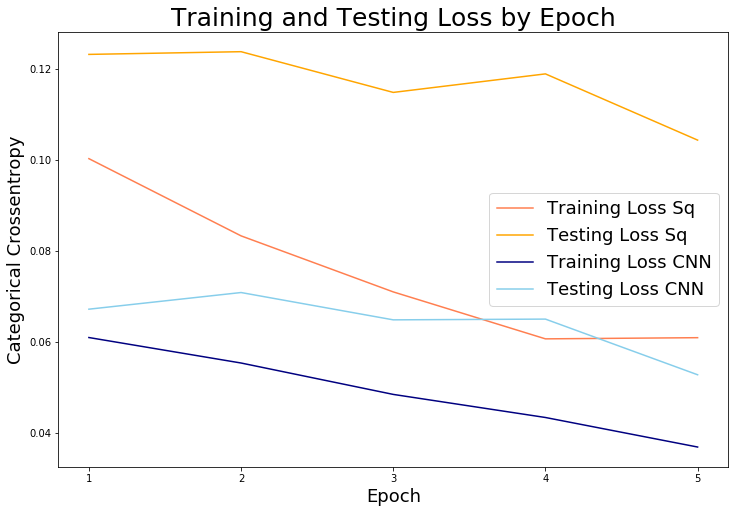

In [54]:
# Code adapted from General Assembly's Data Science Immersive (Lesson 11.04)

# Check out our train loss and test loss over epochs.
train_loss_sq = history_sq.history['loss']
test_loss_sq = history_sq.history['val_loss']
train_loss_cnn = history_cnn.history['loss']
test_loss_cnn = history_cnn.history['val_loss']
train_loss_cnn2 = history_cnn2.history['loss']
test_loss_cnn2 = history_cnn2.history['val_loss']

# Set figure size.
plt.figure(figsize=(10,6))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss_sq, label='Training Loss Sq', color='coral')
plt.plot(test_loss_sq, label='Testing Loss Sq', color='orange')
plt.plot(train_loss_cnn, label='Training Loss CNN', color='navy')
plt.plot(test_loss_cnn, label='Testing Loss CNN', color='skyblue')
plt.plot(train_loss_cnn2, label='Training Loss CNN', color='navy')
plt.plot(test_loss_cnn2, label='Testing Loss CNN', color='skyblue')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])

plt.legend(fontsize = 18);

## Evaluate on Kaggle Test Data

In [22]:
kaggle_test = pd.read_csv('test.csv')
kaggle_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Apply the same preprocessing steps
kaggle_test = kaggle_test.astype('float32')

# Scaling
kaggle_test /= 255

In [25]:
# Change to a numpy array
kaggle_test = kaggle_test.to_numpy()

In [26]:
# Reshape
kaggle_test = kaggle_test.reshape(kaggle_test.shape[0], 28, 28, 1)

In [27]:
kaggle_test.shape

(28000, 28, 28, 1)

In [28]:
model_sq.predict(kaggle_test)

array([[3.41787199e-05, 3.10852499e-09, 9.99902368e-01, ...,
        1.35103349e-07, 5.06666083e-06, 2.57298254e-08],
       [9.99755919e-01, 2.59309942e-08, 1.55727612e-05, ...,
        3.23704853e-07, 1.22012170e-06, 5.02108378e-07],
       [1.14291091e-03, 6.70854643e-04, 4.75515192e-03, ...,
        4.78947256e-03, 9.93301496e-02, 8.21626008e-01],
       ...,
       [7.12014923e-07, 1.63607217e-06, 1.90409264e-05, ...,
        4.92365734e-06, 1.98559021e-04, 1.57070062e-05],
       [1.01627602e-05, 3.73218292e-08, 6.76769432e-08, ...,
        1.91050422e-04, 7.79686379e-05, 9.78987396e-01],
       [1.73375520e-05, 1.35948824e-07, 9.99911547e-01, ...,
        1.21504975e-08, 2.41670223e-05, 3.39635392e-07]], dtype=float32)